## From Spectral Peaks to Harmonic Spectrum Analysis


In this notebook, we will explore the concept of harmonicity and how it can be computed across the whole spectrum to provide indicators of harmonic structures in biological time series. Biological signals, such as brainwaves, often exhibit harmonic relationships. Analyzing the harmonic spectrum of a given biological signal can provide valuable insights into the underlying mechanisms and the prominent frequencies that contribute to its overall structure.

The significance of these multiples, or "harmonics," is that they have a phase relationship with the fundamental frequency which can provide meaningful insights in fields such as music, sound analysis, physics, and neuroscience. 

**Harmonic Spectrum**: This is a computation that examines the harmonic relationships between the frequencies in the signal. For each frequency bin, the computation compares its frequency to every other frequency in the signal to determine the harmonic relationship, which is essentially the ratio of the two frequencies. These ratios are compared to small-integer frequency ratios that characterize musical intervals (e.g., 1:2, 3:4, etc.). The harmonic spectrum is calculated as a weighted sum of these harmonic relationships, where the weights are given by the power of the corresponding frequencies in the spectrum. This creates a single value for each frequency that reflects its harmonic relationship with all other frequencies.

**Phase-Coupling Spectrum**: This is an analysis of the relationships between the phases of different frequency components in the signal. For each frequency bin, the phase differences with all other frequencies are calculated. Each of these phase differences is transformed into a complex number using Euler's formula, with the phase difference as the angle. The mean of these complex numbers is taken, resulting in a complex value that encapsulates the degree and consistency of phase coupling for each frequency bin. The magnitude of this complex value is then taken, resulting in a phase coupling value for each frequency bin that ranges from 0 to 1, indicating the strength of phase coupling with all other frequencies.

**Resonance Spectrum**: The resonance spectrum combines the harmonic and phase coupling measures. Specifically, the harmonic spectrum values and phase coupling values, which are each normalized to lie between 0 and 1, are multiplied together to give the resonance spectrum. This calculation results in a single value for each frequency bin that represents both its harmonic relationship with and phase coupling to all other frequencies.

The harmonic, phase-coupling, and resonance spectrum provide different perspectives on the spectral properties of a signal, giving insight into harmonic relationships, phase relationships, and a measure that combines the two, respectively.

Additional measures provide further characterization of the spectra, including spectral flatness (a measure of the noisiness or tonality of a spectrum), spectral entropy (a quantification of the uncertainty or randomness in the spectrum), spectral spread (a measure of the spread of the spectral distribution), and Higuchi Fractal Dimension (a measure of the complexity of the time series representing each spectrum).


In [1]:
import numpy as np
data = np.load('../data/EEG_example.npy')

c:\Users\Antoine\anaconda3\envs\biotuner\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 6666 is greater than input length  = 4000, using nperseg = 4000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Antoine\anaconda3\envs\biotuner\Lib\site-packages\scipy\signal\_spectral_py.py:1240: UserWarning: nperseg = 6666 is greater than input length  = 4000, using nperseg = 4000
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,


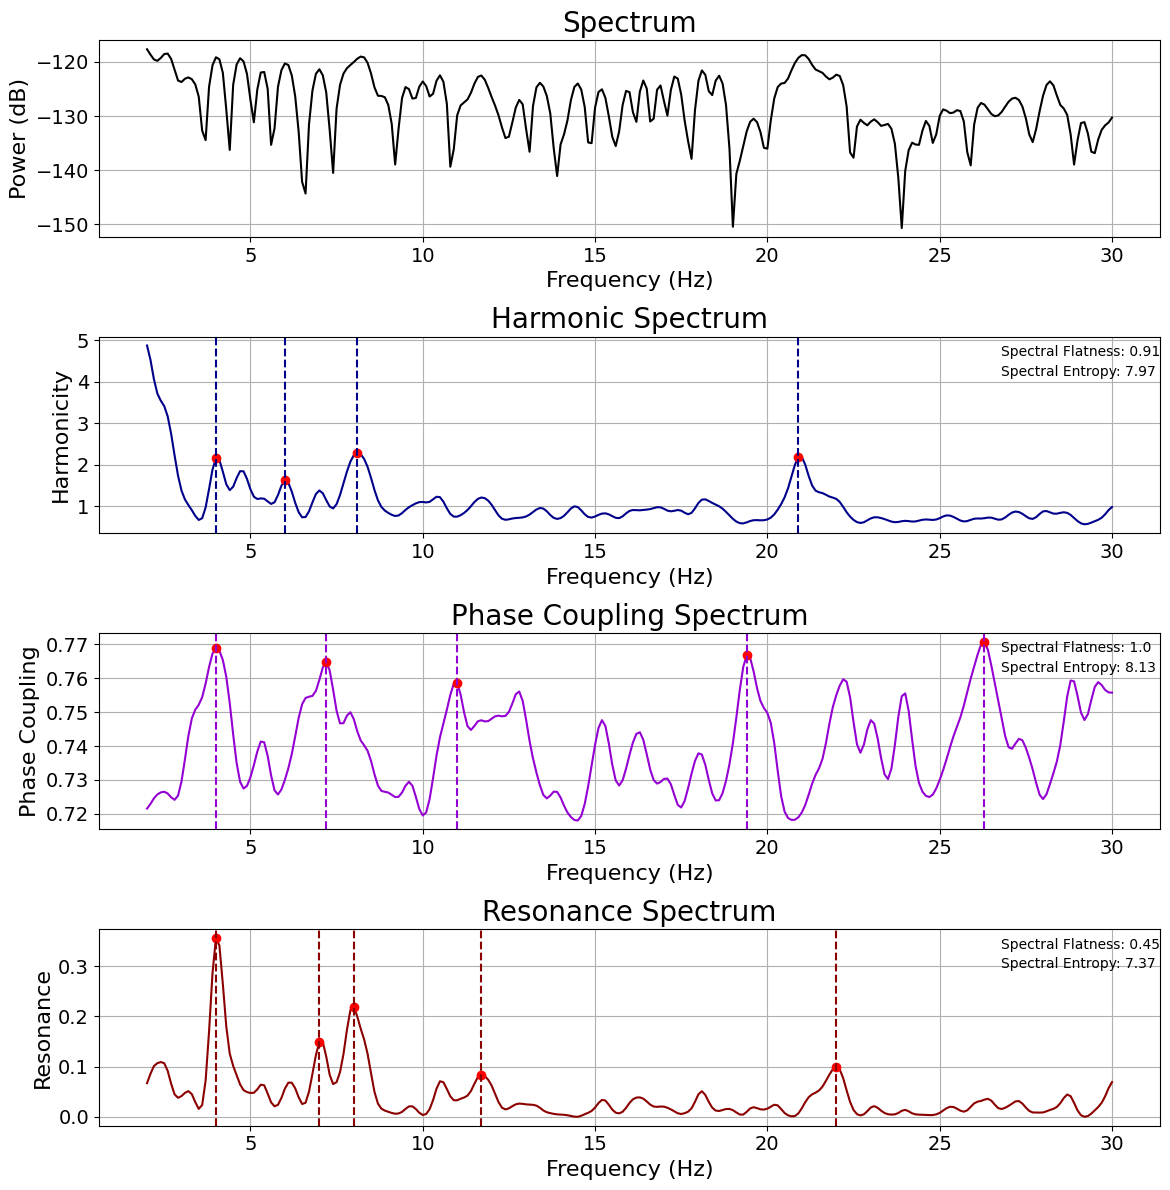

In [ ]:
from biotuner.harmonic_spectrum import compute_global_harmonicity
import numpy as np

harm_spectrum_df, _ = compute_global_harmonicity(data[10], 0.1, 2, 30, fs=1000,
                                             noverlap=1, power_law_remove=True, n_peaks=5, plot=True,
                                             smoothness=1.5, metric='harmsim', delta_lim=500, smoothness_harm=2, 
                                             n_harms=5, phase_mode=None)

### Relation between harmonicity and phase-coupling

We will now look more systematically at the relation between harmonicity and phase-coupling spectrum.

First, let's create a function to call for each list of signals we will process. This will allow to compare harmonic spectrum properties
for different type of signals.

In [22]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from joblib import Parallel, delayed
from tqdm import tqdm

def compute_harmonic_spectrum_parallel(i, signal_list, fs=1000, precision=0.1, fmin=2, fmax=30, noverlap=1, power_law_remove=True, 
                     n_peaks=5, plot=False, smoothness=1.5, metric='harmsim', delta_lim=500, smoothness_harm=2, 
                     n_harms=5, save=False, savename='test', phase_mode=None, normalize=False):
    
    spectrum, _ = compute_global_harmonicity(signal_list[i], precision, fmin, fmax, fs=fs, 
                                          noverlap=noverlap, power_law_remove=power_law_remove, 
                                          n_peaks=n_peaks, plot=plot, smoothness=smoothness, metric=metric, 
                                          delta_lim=delta_lim, smoothness_harm=smoothness_harm, n_harms=n_harms, 
                                          save=save, savename=savename, phase_mode=phase_mode, normalize=normalize)
    spectrum['trial'] = i
    return spectrum


def compute_harmonic_spectrum(signal_list, n_jobs=-1, **kwargs):
    
    df_list = Parallel(n_jobs=n_jobs)(
        delayed(compute_harmonic_spectrum_parallel)(i, signal_list, **kwargs) 
        for i in tqdm(range(len(signal_list)), desc="Computing harmonic spectrum")
    )
    
    df = pd.concat(df_list, axis=0)
    
    return df


Then, we compute the spectrum for 100 trials in both brain signal and randomly generated signals

In [11]:
# generate 100 random signals of 4000 datapoints
data_rnd = np.random.rand(10, 4000)

# take 100 epochs of the EEG example data
brain_data = data[:10]

df_brain = compute_harmonic_spectrum(brain_data)
df_random = compute_harmonic_spectrum(data_rnd)

Computing harmonic spectrum: 100%|██████████| 10/10 [00:00<00:00, 10087.31it/s]


Additionally to real brain signal and purely random signals, we will generate signals in which we control for the level of harmonicity between oscillations.
To do so, we use the neurodsp toolbox to simulate brain signals with chosen oscillations and aperiodic component.

In [14]:
from biotuner.biotuner_utils import generate_signal
from neurodsp.sim import sim_combined

sf = 1000
freqs_harm = [2, 6, 12, 18, 24, 30]
freqs_noharm = [2, 5.1, 13.1, 17.7, 25.6, 29.9]

# Set up simulation parameters for neurodsp
n_seconds = 10  # Set n_seconds to 10
components_harm = {
    'sim_powerlaw': {'exponent': -1.0}, 
    'sim_oscillation': [{'freq': freq} for freq in freqs_harm]  # list of dictionaries
}
components_noharm = {
    'sim_powerlaw': {'exponent': -1.0}, 
    'sim_oscillation': [{'freq': freq} for freq in freqs_noharm]  # list of dictionaries
}

# Each component (aperiodic & oscillatory) needs a variance
component_variances = [10 for _ in range(len(freqs_noharm) + 1)]  # +1 for the 'sim_powerlaw' component

# Simulate the signals 100 times
brain_signal_harm = [sim_combined(n_seconds, sf, components_harm, component_variances) for _ in range(10)]
brain_signal_noharm = [sim_combined(n_seconds, sf, components_noharm, component_variances) for _ in range(10)]


In [15]:
# Compute harmonic spectrums
df_brain_sim_harm = compute_harmonic_spectrum(brain_signal_harm)
df_brain_sim_noharm = compute_harmonic_spectrum(brain_signal_noharm)

Computing harmonic spectrum: 100%|██████████| 10/10 [00:00<00:00, 9991.20it/s]


#### Correlation between averaged harmonicity and phase-coupling spectrum for random and brain signals

First, we will look at the relation between the averaged harmonicity and phase-coupling across the whole spectrum for the 100 trials. Each trial corresponds to a datapoint.

Brain Signals - correlation:  -0.9473058367923763 p-value:  3.164448439918354e-05
Random Signals - correlation:  -0.9683530570408556 p-value:  4.223921666247223e-06


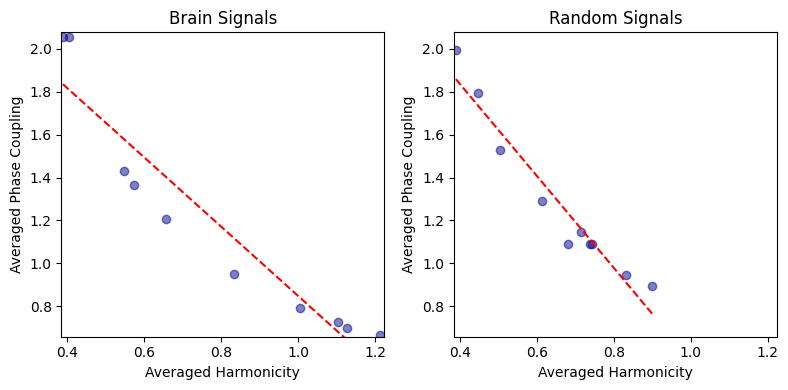

Brain Simulation - Harmonic - correlation:  -0.9628445090331682 p-value:  7.972112131283355e-06
Brain Simulation - Non Harmonic - correlation:  -0.984312093471142 p-value:  2.600390853574861e-07


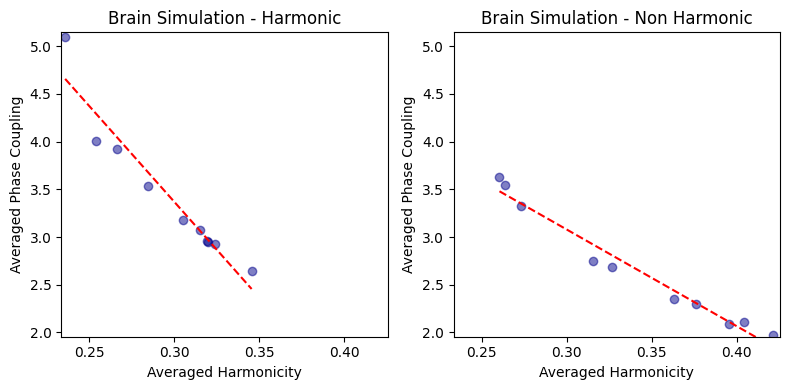

In [16]:
from biotuner.harmonic_spectrum import harmonic_spectrum_plot_avg_corr
harmonic_spectrum_plot_avg_corr(df_brain, df_random)
harmonic_spectrum_plot_avg_corr(df_brain_sim_harm, df_brain_sim_noharm, label1='Brain Simulation - Harmonic', label2='Brain Simulation - Non Harmonic')

*This negative correlation is pretty intense!*

I suspect it might be due to the operation of normalizing the *harmonicity* and *phase-coupling* values by the *total power* (2*total_power).

**It is important to know** that the PSD values used for deriving the total power have been normalized between 0 and 1, preventing drastic effects of power differences between signals.

*However*, we still see this **strong negative correlation**.

It might be driven by the *variability* in total power across signals.

To better investigate, we will look at the correlations ***within trial*** (correlating the values of the *harmonicity* and *phase-coupling spectrum* of all frequencies for each trial), and ***within frequency*** (correlating the harmonicity and phase-coupling values of all the trials for each frequency).


#### Within-trial correlations for random and brain signals

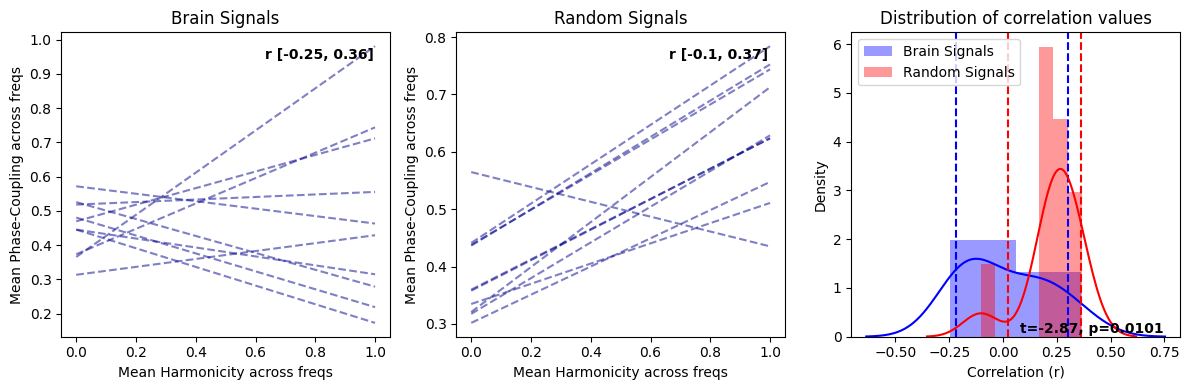

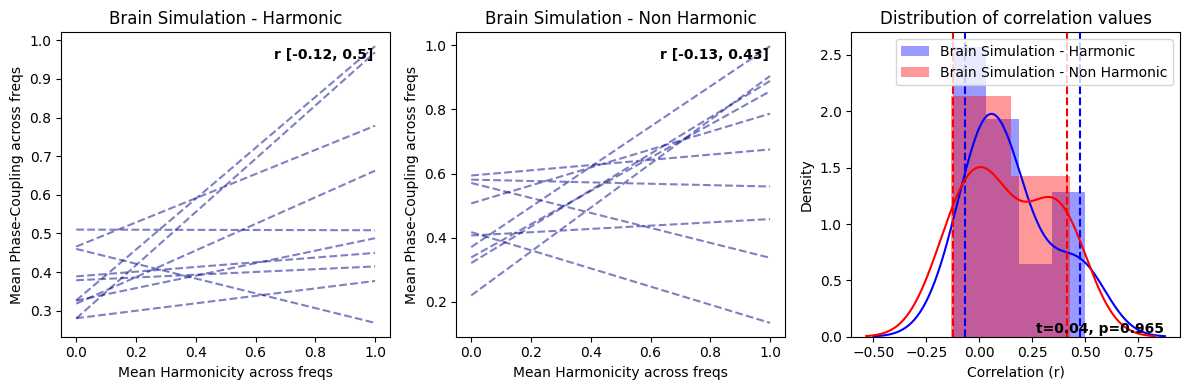

In [18]:
from biotuner.harmonic_spectrum import harmonic_spectrum_plot_trial_corr

harmonic_spectrum_plot_trial_corr(df_brain, df_random)
harmonic_spectrum_plot_trial_corr(df_brain_sim_harm, df_brain_sim_noharm, label1='Brain Simulation - Harmonic', label2='Brain Simulation - Non Harmonic')

#### Within-frequency correlations for random and brain signals

Next, we compute the correlation between harmonicity and phase-coupling for each frequency bin across the 100 trials. 

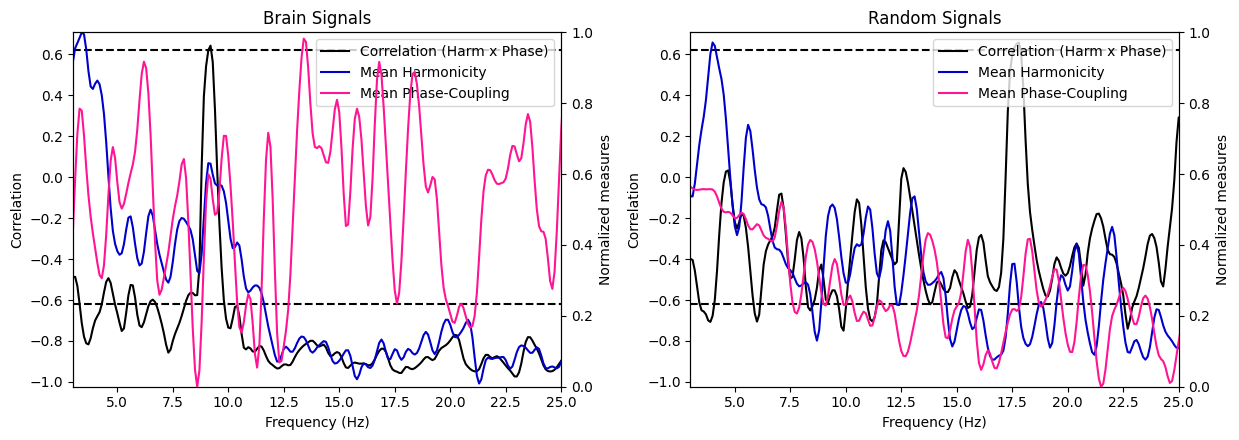

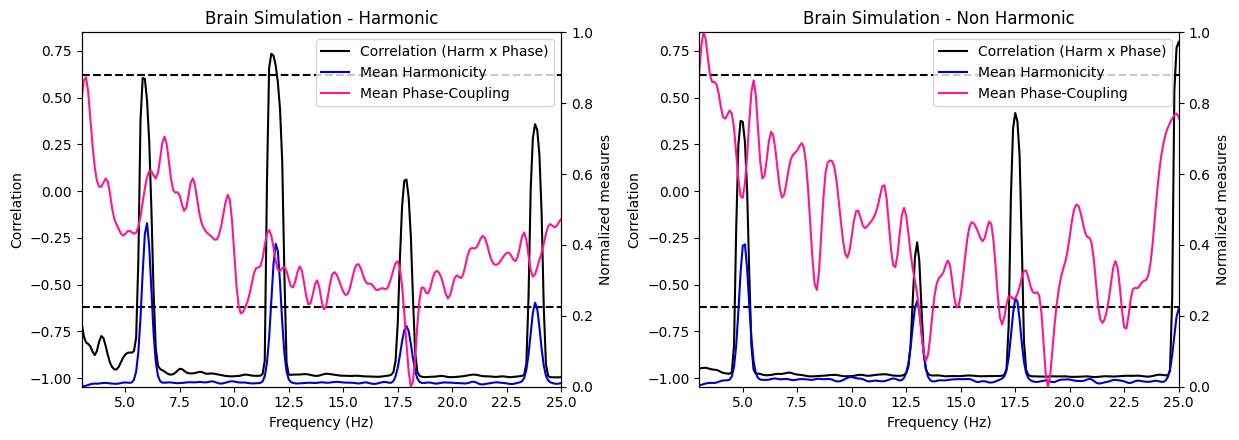

In [19]:
from biotuner.harmonic_spectrum import harmonic_spectrum_plot_freq_corr
harmonic_spectrum_plot_freq_corr(df_brain, df_random, label1='Brain Signals', label2='Random Signals',
                                 mean_phase_coupling=True, xlim=(3, 25))
harmonic_spectrum_plot_freq_corr(df_brain_sim_harm, df_brain_sim_noharm, label1='Brain Simulation - Harmonic', label2='Brain Simulation - Non Harmonic',
                                 xlim=((3, 25)), mean_phase_coupling=True)

#### Brain signal VS Random signal

In general, the negative correlations across frequencies are much stronger in brain signals than in random signals, suggesting a stronger relationship between harmonicity and phase coupling in brain signals. Moreover, we see that in brain signals, higher harmonicity of a frequency tends to be associated with weaker correlations (specifically salient around 9Hz) while for random signals, we see an opposite trends (lower harmonicity tends to be associated with weaker correlations). Finally, we can observe a systematic decrease of harmonicity with increased in frequency specifically for random signals, while brain signals exhibit clear bumps of harmonicity in low-mid frequencies (around the theta/alpha bands).

These results suggest that the relationship between these two measures in brain signals is different than in random signals.

#### Harmonic vs Non-Harmonic Brain simulation

#### We will now compare harmonicity and phase-coupling without normalizing the values by the total spectrum power

In [23]:
df_brain_no_norm = compute_harmonic_spectrum(brain_data, normalize=False)
df_random_no_norm = compute_harmonic_spectrum(data_rnd, normalize=False)
df_brain_sim_harm_no_norm = compute_harmonic_spectrum(brain_signal_harm, normalize=False)
df_brain_sim_noharm_no_norm = compute_harmonic_spectrum(brain_signal_noharm, normalize=False)

Computing harmonic spectrum: 100%|██████████| 10/10 [00:00<00:00, 10353.75it/s]


#### Correlation between averaged harmonicity and phase-coupling spectrum for random and brain signals

Brain Signals - correlation:  -0.3926393021034822 p-value:  0.2617156390079268
Random Signals - correlation:  0.07115714391427305 p-value:  0.8451294965939938


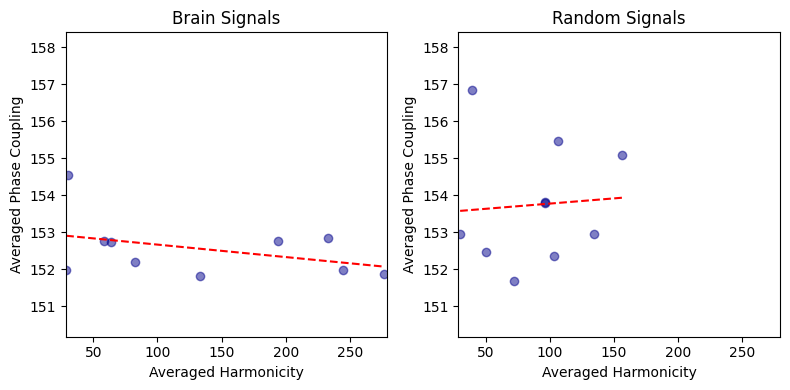

Brain Simulation - Harmonic - correlation:  -0.5820481942133179 p-value:  0.07750835028850563
Brain Simulation - Non Harmonic - correlation:  -0.02460716458915993 p-value:  0.9462044092553757


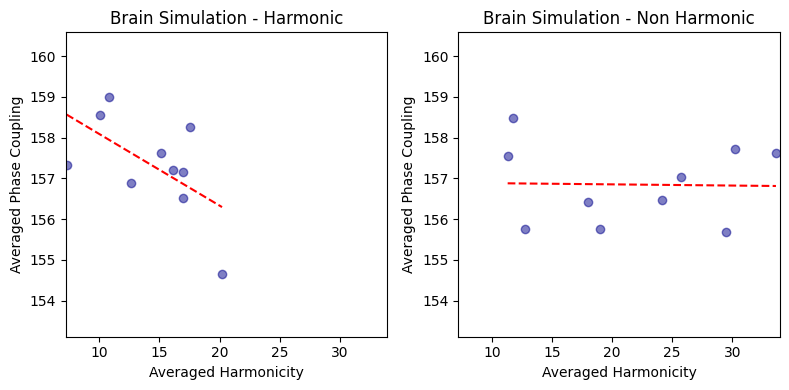

In [24]:
harmonic_spectrum_plot_avg_corr(df_brain_no_norm, df_random_no_norm)
harmonic_spectrum_plot_avg_corr(df_brain_sim_harm_no_norm, df_brain_sim_noharm_no_norm, label1='Brain Simulation - Harmonic', label2='Brain Simulation - Non Harmonic')

This clearly demonstrates that the negative correlation of the averaged harmonicity and phase-coupling was caused by the normalization of these values by the total power of the spectrum.

#### Within-trial correlations for random and brain signals

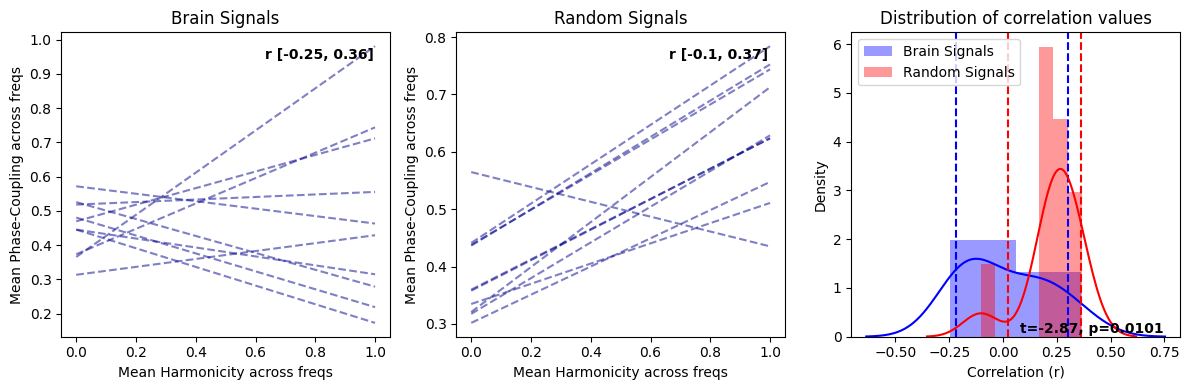

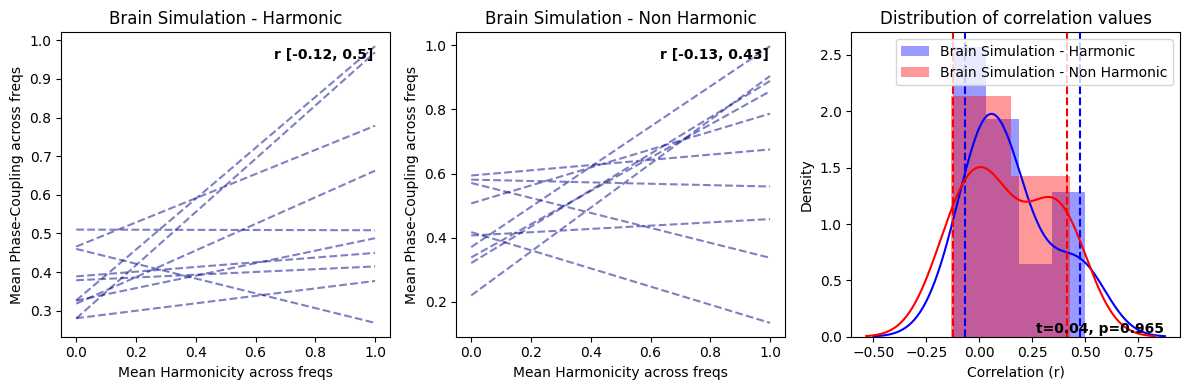

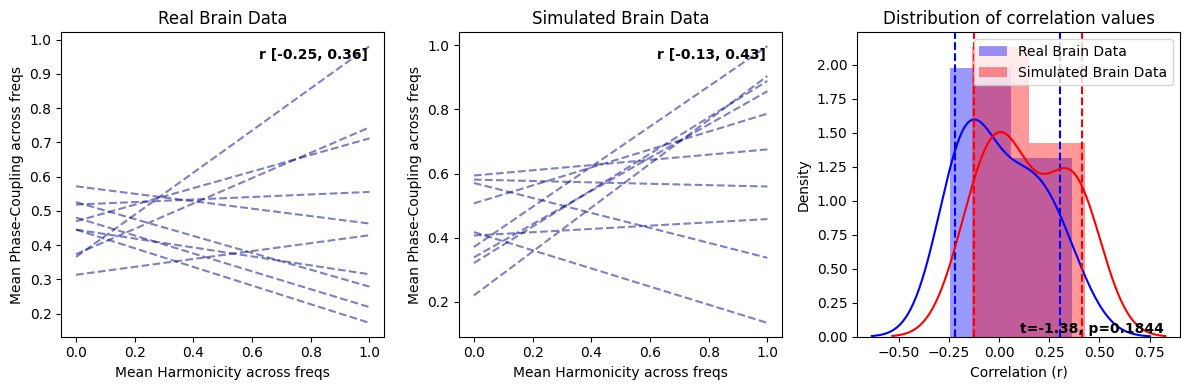

In [25]:
harmonic_spectrum_plot_trial_corr(df_brain_no_norm, df_random_no_norm)
harmonic_spectrum_plot_trial_corr(df_brain_sim_harm_no_norm, df_brain_sim_noharm_no_norm, label1='Brain Simulation - Harmonic', label2='Brain Simulation - Non Harmonic')
harmonic_spectrum_plot_trial_corr(df_brain_no_norm, df_brain_sim_noharm_no_norm, label1='Real Brain Data', label2='Simulated Brain Data')

In replicating the effects similar to those observed with normalization, we have also discovered that genuine brain signals typically display more pronounced negative correlations in contrast to their simulated counterparts. This trend is not simply attributable to increased randomness in the signal as purely random data exhibit positive correlations between within-trial harmonicity and phase-coupling. Consequently, the heightened negative correlation observed between harmonicity and phase-coupling may be shaped by factors beyond the aperiodic component and oscillators, which are the principal constituents in the simulated brain signal. This suggests that there could be more intricate dynamics at play in the real brain signals, warranting further exploration.

#### Within-frequency correlations for random and brain signals

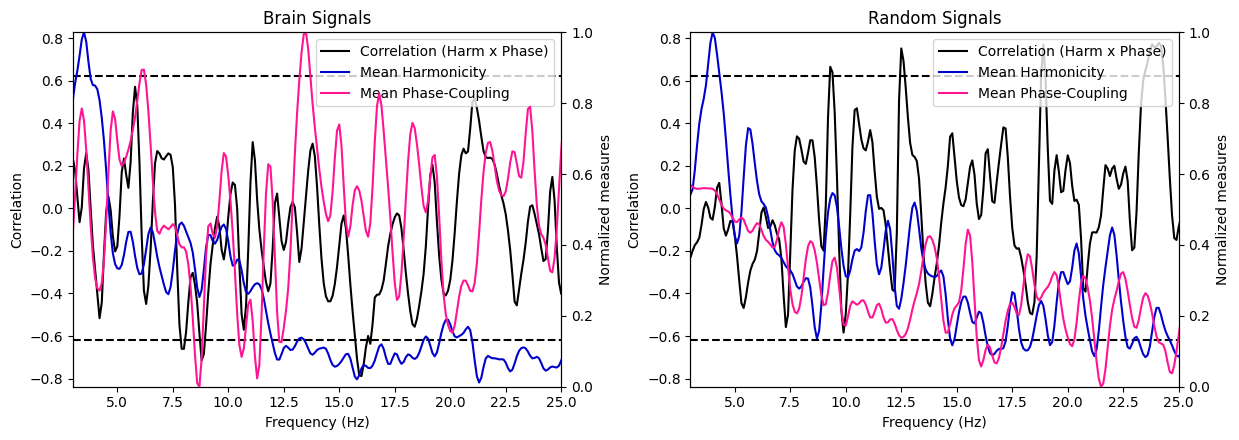

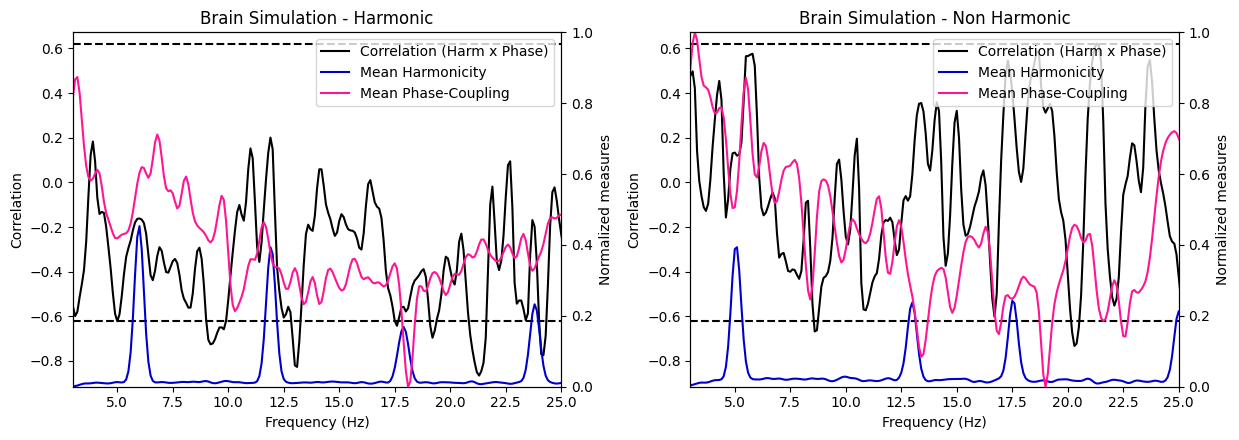

In [26]:
harmonic_spectrum_plot_freq_corr(df_brain_no_norm, df_random_no_norm, label1='Brain Signals', label2='Random Signals', fmin=2, fmax=30,
                                 mean_phase_coupling=True, xlim=(3, 25))
harmonic_spectrum_plot_freq_corr(df_brain_sim_harm_no_norm, df_brain_sim_noharm_no_norm, label1='Brain Simulation - Harmonic', label2='Brain Simulation - Non Harmonic',
                                 mean_phase_coupling=True, xlim=(3, 25))